## Imports

In [1]:
import os
import sys
import pathlib
import warnings
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()

import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from llmicl.interfaces import trainers
from llmicl.rl_helpers import nn_utils

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

2024-09-26 18:50:07.592569: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 18:50:07.608287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 18:50:07.627015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 18:50:07.632795: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 18:50:07.648400: I tensorflow/core/platform/cpu_feature_guar

<Figure size 640x480 with 0 Axes>

## states and actions names

In [2]:
state_names = {
    "HalfCheetah": [
        "rootz",
        "rooty",
        "bthigh",
        "bshin",
        "bfoot",
        "fthigh",
        "fshin",
        "ffoot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "bthigh_dot",
        "bshin_dot",
        "bfoot_dot",
        "fthigh_dot",
        "fshin_dot",
        "ffoot_dot",
        # "reward",
    ],
    "Hopper": [
        "rootz",
        "rooty",
        "thigh",
        "leg",
        "foot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_dot",
        "leg_dot",
        "foot_dot",
        # "reward",
    ],
    "Ant": [
        "rootz",
        "root_quat_x",
        "root_quat_y",
        "root_quat_z",
        "root_quat_w",
        "hip_1_angle",
        "ankle_1_angle",
        "hip_2_angle",
        "ankle_2_angle",
        "hip_3_angle",
        "ankle_3_angle",
        "hip_4_angle",
        "ankle_4_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "root_quat_x_dot",
        "root_quat_y_dot",
        "root_quat_z_dot",
        "hip_1_angle_dot",
        "ankle_1_angle_dot",
        "hip_2_angle_dot",
        "ankle_2_angle_dot",
        "hip_3_angle_dot",
        "ankle_3_angle_dot",
        "hip_4_angle_dot",
        "ankle_4_angle_dot",
        # "reward",
    ],
    "Walker2d": [
        "rootz",
        "rooty",
        "thigh_right_angle",
        "leg_right_angle",
        "foot_right_angle",
        "thigh_left_angle",
        "leg_left_angle",
        "foot_left_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_right_angle_dot",
        "leg_right_angle_dot",
        "foot_right_angle_dot",
        "thigh_left_angle_dot",
        "leg_left_angle_dot",
        "foot_left_angle_dot",
        # "reward",
    ],
    "Swimmer": [
        r"$free\_body_rot$",
        r"$motor1\_rot$",
        r"$motor2\_rot$",
        r"$slider1$",
        r"$slider2$",
        r"$\dot{free\_body\_rot}$",
        r"$\dot{motor1\_rot}$",
        r"$\dot{motor2\_rot}$",
    ],
    "CartPole": [
        r"$x$",
        r"$cos(\theta)$",
        r"$sin(\theta)$",
        r"$\dot{x}$",
        r"$\dot{\theta}$",
    ],
}

action_names = {
    "HalfCheetah": [
        "t_bthigh",
        "t_bshin",
        "t_bfoot",
        "t_fthigh",
        "t_fshin",
        "t_ffoot",
    ],
    "Hopper": [
        "thigh_joint",
        "leg_joint",
        "foot_joint",
    ],
    "Ant": [
        "hip_4_joint",
        "ankle_4_joint",
        "hip_1_joint",
        "ankle_1_joint",
        "hip_2_joint",
        "ankle_2_joint",
        "hip_3_joint",
        "ankle_3_joint",
    ],
    "Walker2d": [
        "thigh_left_joint",
        "leg_left_joint",
        "foot_left_joint",
        "thigh_right_joint",
        "leg_right_joint",
        "foot_right_joint",
    ],
    "Swimmer": [
        "joint_1",
        "joint_2",
    ],
}

new_notation_state = {
    "HalfCheetah": [
        r"$rootz$",
        r"$rooty$",
        r"$bthigh$",
        r"$bshin$",
        r"$bfoot$",
        r"$fthigh$",
        r"$fshin$",
        r"$ffoot$",
        r"$\dot{rootx}$",
        r"$\dot{rootz}$",
        r"$\dot{rooty}$",
        r"$\dot{bthigh}$",
        r"$\dot{bshin}$",
        r"$\dot{bfoot}$",
        r"$\dot{fthigh}$",
        r"$\dot{fshin}$",
        r"$\dot{ffoot}$",
    ],
    "Hopper": [
        r"$rootz$",
        r"$rooty$",
        r"$thigh$",
        r"$leg$",
        r"$foot$",
        r"$\dot{rootx}$",
        r"$\dot{rootz}$",
        r"$\dot{rooty}$",
        r"$\dot{thigh}$",
        r"$\dot{leg}$",
        r"$\dot{foot}$",
    ],
}

# Helpers

## load model and tokenizer

In [3]:
import torch
from transformers import LlamaForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    # "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    # "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
print(f"finish loading model")
model.eval()

finish loading tokenizer
finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
    (rotary_emb): Ll

# Generate data

## load env, actor, data

In [4]:
env_name = "Walker2d"
if env_name != 'CartPole':
    env = gym.make(env_name)
    n_actions = env.action_space.shape[0]
    n_observations = env.observation_space.shape[0]
else:
    n_actions = 1
    n_observations = 5

# load some data to get a pool of states
data_label = "expert"
data_path = f"/home/abenechehab/datasets/{env_name}/{data_label}/X_test.csv"
X = pd.read_csv(data_path, index_col=0)
X = X.values.astype('float')

# find episodes beginnings
restart_index = n_observations+n_actions 
restarts = X[:, restart_index+1]
episode_starts = np.where(restarts)[0]
episode_starts

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `Walker2d-v4` instead of the unversioned environment `Walker2d`.
  logger.warn(


array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000, 19000])

In [48]:
only_use_context = False

obs = X[:, :n_observations]
obs = obs[~np.isnan(obs[:, -1])]

obs_act = X[:, : n_observations + n_actions]
obs_act = obs_act[~np.isnan(obs_act[:, -1])]

# standard scaling
scaling_pipeline = make_pipeline(MinMaxScaler(), StandardScaler())
scaling_pipeline.fit(obs)
obs_scaled = scaling_pipeline.transform(obs)

scaling_pipeline_act = make_pipeline(MinMaxScaler(), StandardScaler())
scaling_pipeline_act.fit(obs_act)
obs_act_scaled = scaling_pipeline_act.transform(obs_act)

# pca
pca_with_actions = False
n_components = n_observations
n_components += n_actions if pca_with_actions else 0
# pca = FastICA(n_components=n_components)  # PCA
pca = PCA(n_components=n_components)
if pca_with_actions:
    pca.fit(obs_act_scaled)
else:
    pca.fit(obs_scaled)

#### if no scaling, run this

In [6]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, input_array, y=None):
        return self

    def transform(self, input_array, y=None):
        return input_array * 1

    def inverse_transform(self, input_array, y=None):
        return input_array * 1


scaling_pipeline = IdentityTransformer()
scaling_pipeline_act = IdentityTransformer()

#### if no pca

In [12]:
pca_with_actions = False
pca = IdentityTransformer()
n_components = n_observations

# ICL

In [49]:
context_length = 400
rescale_factor = 7.0
up_shift = 1.5

icl_objects_list = []

n_episodes = 3

print(f"episode starts: {episode_starts}")

selected_episodes = []
for episode in tqdm(np.random.choice(episode_starts, (n_episodes,)), desc="episode"):
    selected_episodes.append(episode)
    if pca_with_actions:
        time_series = pca.transform(
            scaling_pipeline_act.transform(
                X[episode : episode + context_length, :n_components]
            )
        )
    else:
        time_series = pca.transform(
            scaling_pipeline.transform(
                X[episode : episode + context_length, :n_components]
            )
        )

    trainer = trainers.RLICLTrainer(
        model=model,
        tokenizer=tokenizer,
        n_observations=n_components,
        n_actions=n_actions,
        rescale_factor=rescale_factor,
        up_shift=up_shift,
    )

    trainer.update_context(
        time_series=copy.copy(time_series),
        mean_series=copy.copy(time_series),
        sigma_series=np.zeros_like(time_series),
        context_length=context_length,
        update_min_max=True,
    )

    trainer.icl(verbose=0, stochastic=True)

    icl_objects_list.append(trainer.compute_statistics())

episode starts: [    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000 19000]


episode:   0%|          | 0/3 [00:00<?, ?it/s]/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr
episode:  33%|███▎      | 1/3 [00:13<00:27, 13.53s/it]/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_hei

# Error plots

## llm alone

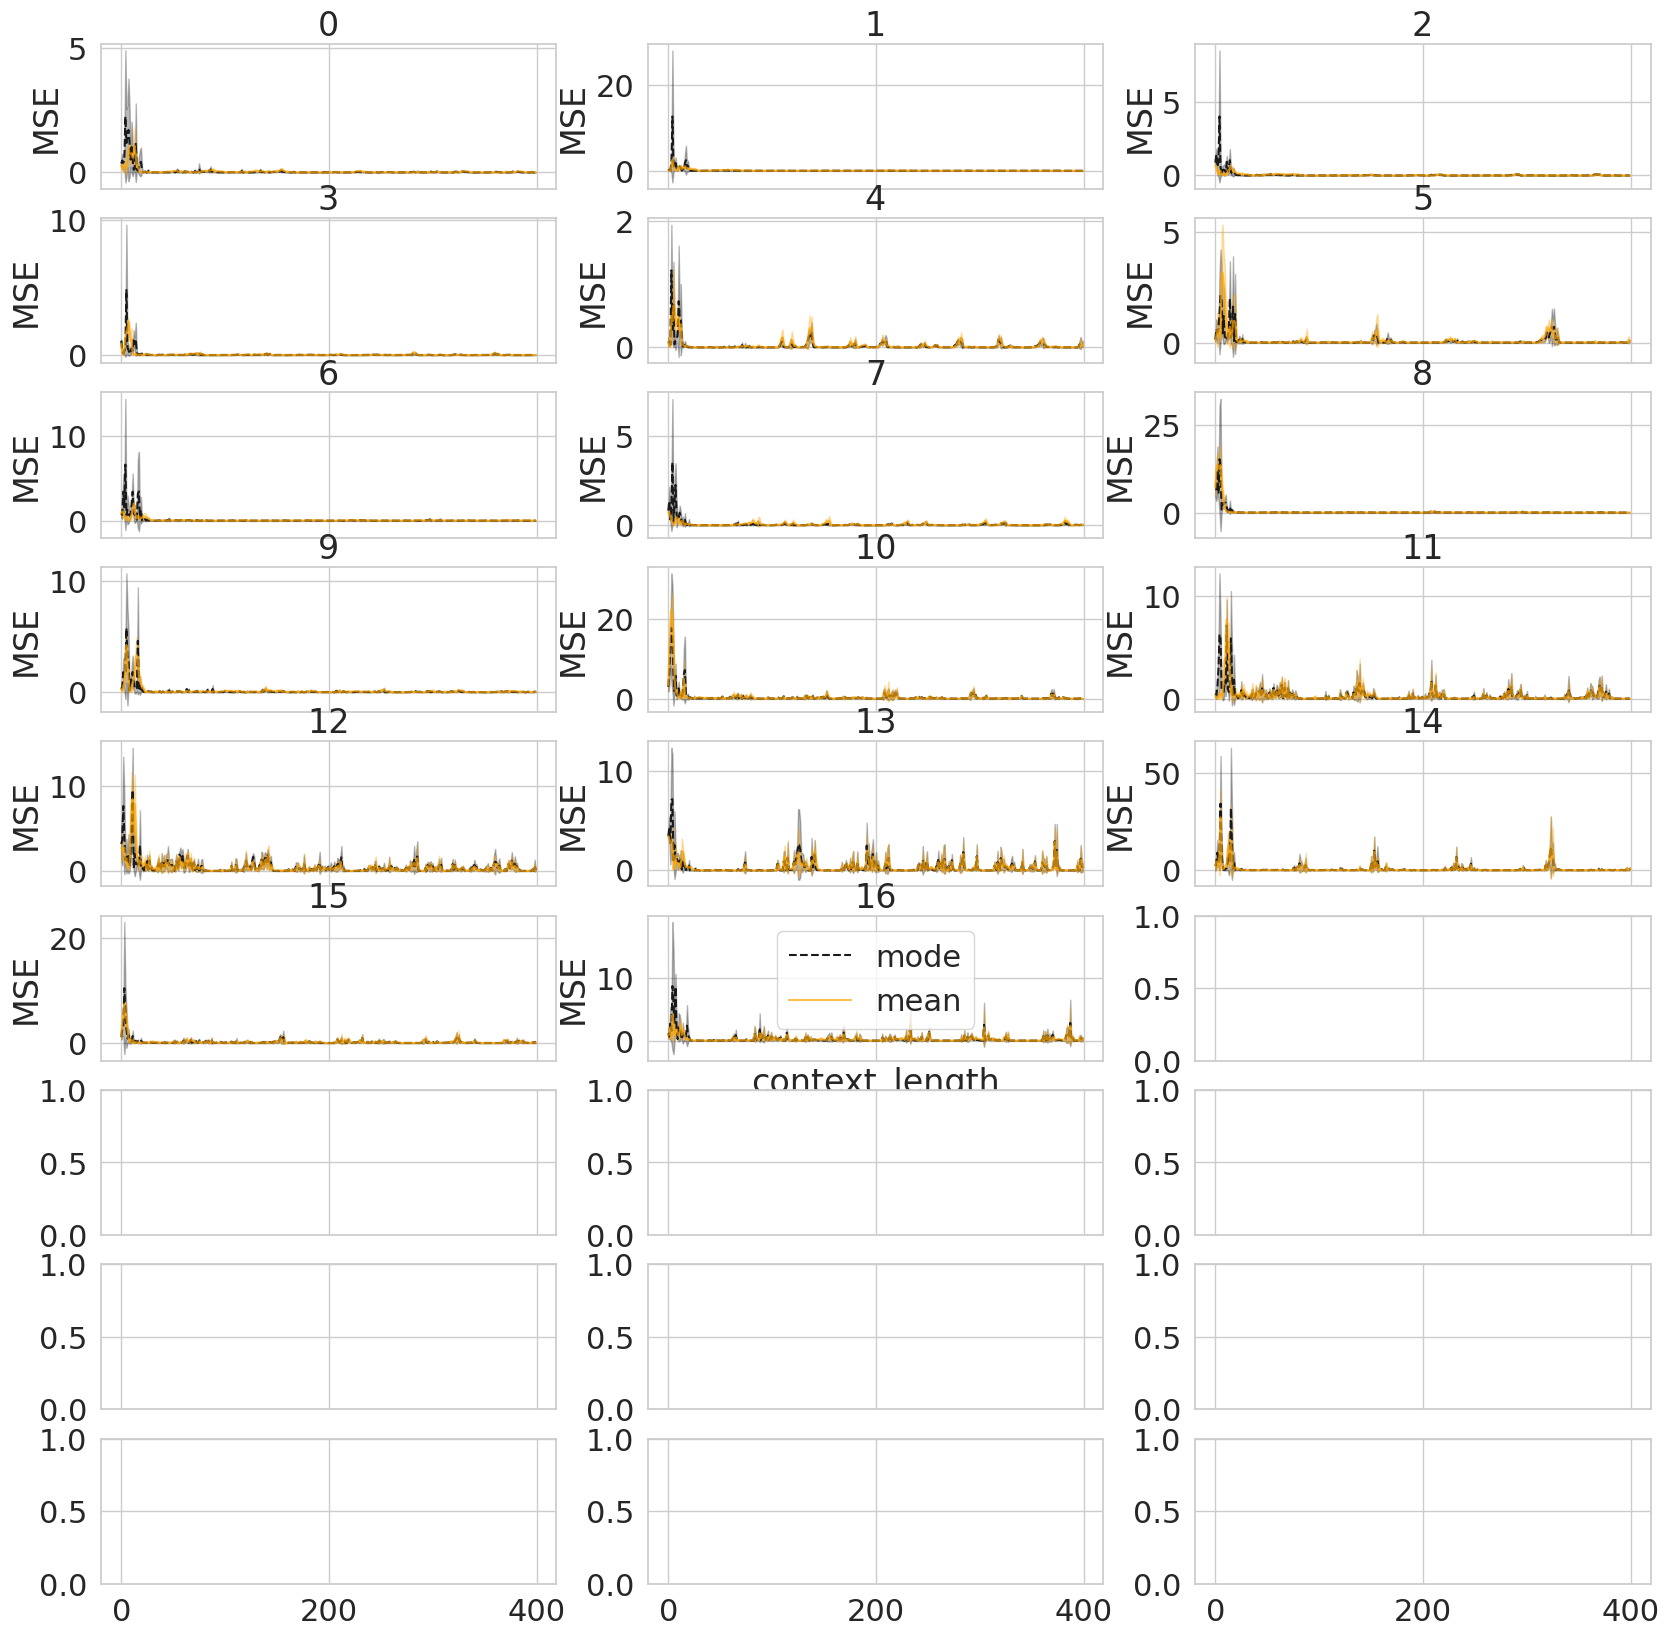

In [50]:
# Initialize lists to store the arrays for each dimension
mean_arr_list = []
mode_arr_list = []

for dim in range(n_components):
    mean_arr_dim = [
        (
            ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor)
            * (icl_object[dim].rescaling_max - icl_object[dim].rescaling_min)
            + icl_object[dim].rescaling_min
        )[None, ...]
        for icl_object in icl_objects_list
    ]
    mean_arr_dim = np.concatenate(mean_arr_dim, axis=0)
    mean_arr_list.append(mean_arr_dim)

    mode_arr_dim = [
        (
            ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor)
            * (icl_object[dim].rescaling_max - icl_object[dim].rescaling_min)
            + icl_object[dim].rescaling_min
        )[None, ...]
        for icl_object in icl_objects_list
    ]
    mode_arr_dim = np.concatenate(mode_arr_dim, axis=0)
    mode_arr_list.append(mode_arr_dim)

# Stack the arrays along the last dimension
mean_arr_all_pca = np.stack(mean_arr_list, axis=-1)
mode_arr_all_pca = np.stack(mode_arr_list, axis=-1)

mean_arr_all_pca = pca.inverse_transform(mean_arr_all_pca)
mode_arr_all_pca = pca.inverse_transform(mode_arr_all_pca)

groundtruth_all = []
for episode in selected_episodes:
    groundtruth_all.append(
        scaling_pipeline.transform(
            X[episode + 1 : episode + context_length + 1, :n_observations]
        )[None, ...]
    )
groundtruth_all = np.concatenate(groundtruth_all, axis=0)

f, axes = plt.subplots(9, 3, figsize=(20, 20), gridspec_kw={"wspace": 0.2}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = groundtruth_all[:, :, dim]

    # -------------------- Useful for Plots --------------------
    mean_arr_all = mean_arr_all_pca[:, :, dim]
    mode_arr_all = mode_arr_all_pca[:, :, dim]

    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr_all.shape[1])
    mean_error = np.power(groundtruth - mean_arr_all, 2)
    mode_error = np.power(groundtruth - mode_arr_all, 2)

    axes[dim].plot(x, mode_error.mean(axis=0), "k--", label="mode")
    axes[dim].fill_between(
        x=x,
        y1=mode_error.mean(axis=0) - mode_error.std(axis=0),
        y2=mode_error.mean(axis=0) + mode_error.std(axis=0),
        color="k",
        alpha=0.3,
    )
    axes[dim].plot(x, mean_error.mean(axis=0), label="mean", color="orange", alpha=0.7)
    axes[dim].fill_between(
        x=x,
        y1=mean_error.mean(axis=0) - mean_error.std(axis=0),
        y2=mean_error.mean(axis=0) + mean_error.std(axis=0),
        color="orange",
        alpha=0.3,
    )
    axes[dim].set_title(f"{dim}")
    if dim > 15:
        axes[dim].set_xlabel("context_length")
    axes[dim].set_ylabel("MSE")
axes[dim].legend()
# plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
plt.show()

## baselines

In [51]:
sub_context_size_list = [10, 100, 200, context_length-1]

linreg_pred_all_episodes = []
linreg_actions_pred_all_episodes = []
mlp_pred_all_episodes = []
mlp_actions_pred_all_episodes = []
for episode in tqdm(selected_episodes, desc="episode"):
    linreg_pred_all = []
    linreg_actions_pred_all = []
    mlp_pred_all = []
    mlp_actions_pred_all = []
    for sub_context_size in sub_context_size_list:
        X_train_actions = scaling_pipeline_act.transform(
            copy.copy(
                np.concatenate(
                    [
                        X[episode : episode + sub_context_size, :n_observations],
                        X[
                            episode : episode + sub_context_size,
                            n_observations : n_observations + n_actions,
                        ],
                    ],
                    axis=1,
                )[:-1]
            )
        )  # TODO: halfcheetah have obs_reward as additional obs
        X_train = scaling_pipeline.transform(
            copy.copy(X[episode : episode + sub_context_size - 1, :n_observations])
        )
        y_train = scaling_pipeline.transform(
            copy.copy(X[episode + 1 : episode + sub_context_size, :n_observations])
        )

        nan_indices = np.unique(np.argwhere(np.isnan(X_train_actions))[:, 0])
        mask = np.ones(X_train_actions.shape[0], bool)
        mask[nan_indices] = False

        X_train = X_train[mask]
        X_train_actions = X_train_actions[mask]
        y_train = y_train[mask]

        # ------- Fit Linear regression -------
        linreg_model = LinearRegression(fit_intercept=True)
        linreg_model.fit(X_train, y_train)
        linreg_input = scaling_pipeline.transform(
            X[
                episode + sub_context_size - 1,
                :n_observations,
            ][None, ...]
        ).squeeze()
        linreg_pred_all.append(linreg_model.predict(linreg_input[None, ...]))

        # ------- Fit Linear regression with actions -------
        linreg_model = LinearRegression(fit_intercept=True)
        linreg_model.fit(X_train_actions, y_train)
        linreg_input = scaling_pipeline_act.transform(
            np.concatenate(
                [
                    X[episode + sub_context_size - 1, :n_observations][None, ...],
                    X[
                        episode + sub_context_size - 1,
                        n_observations : n_observations + n_actions,
                    ][None, ...],
                ],
                axis=1,
            )
        )
        linreg_actions_pred_all.append(linreg_model.predict(linreg_input))

        # ------- Fit MLP -------
        mlp = nn_utils.NeuralNet(input_size=n_observations, output_size=n_observations)
        _, _, mlp = nn_utils.train_mlp(model=mlp, X_train=X_train, y_train=y_train)
        mlp.eval()
        mlp_input = scaling_pipeline.transform(
            X[
                episode + sub_context_size - 1,
                :n_observations,
            ][None, ...]
        ).squeeze()
        mlp_pred = (
            mlp(torch.from_numpy(mlp_input[None, ...]).type(torch.FloatTensor))
            .cpu()
            .detach()
            .numpy()
        )
        mlp_pred_all.append(mlp_pred)

        # ------- Fit MLP with actions -------
        mlp_actions = nn_utils.NeuralNet(
            input_size=n_observations + n_actions, output_size=n_observations
        )
        _, _, mlp_actions = nn_utils.train_mlp(
            model=mlp_actions, X_train=X_train_actions, y_train=y_train
        )
        mlp_actions.eval()
        mlp_input_actions = scaling_pipeline_act.transform(
            np.concatenate(
                [
                    X[episode + sub_context_size - 1, :n_observations][None, ...],
                    X[
                        episode + sub_context_size - 1,
                        n_observations : n_observations + n_actions,
                    ][None, ...],
                ],
                axis=1,
            )
        )
        mlp_actions_pred = (
            mlp_actions(torch.from_numpy(mlp_input_actions).type(torch.FloatTensor))
            .cpu()
            .detach()
            .numpy()
        )
        mlp_actions_pred_all.append(mlp_actions_pred)

    linreg_pred_all_episodes.append(np.concatenate(linreg_pred_all, axis=0)[None, ...])
    linreg_actions_pred_all_episodes.append(
        np.concatenate(linreg_actions_pred_all, axis=0)[None, ...]
    )
    mlp_pred_all_episodes.append(np.concatenate(mlp_pred_all, axis=0)[None, ...])
    mlp_actions_pred_all_episodes.append(
        np.concatenate(mlp_actions_pred_all, axis=0)[None, ...]
    )

linreg_pred_all_episodes = np.concatenate(linreg_pred_all_episodes, axis=0)
linreg_actions_pred_all_episodes = np.concatenate(
    linreg_actions_pred_all_episodes, axis=0
)
mlp_pred_all_episodes = np.concatenate(mlp_pred_all_episodes, axis=0)
mlp_actions_pred_all_episodes = np.concatenate(mlp_actions_pred_all_episodes, axis=0)

episode:   0%|          | 0/3 [00:00<?, ?it/s]

episode: 100%|██████████| 3/3 [00:26<00:00,  8.93s/it]


## final vizu

episode: 100%|██████████| 3/3 [00:00<00:00, 1763.30it/s]


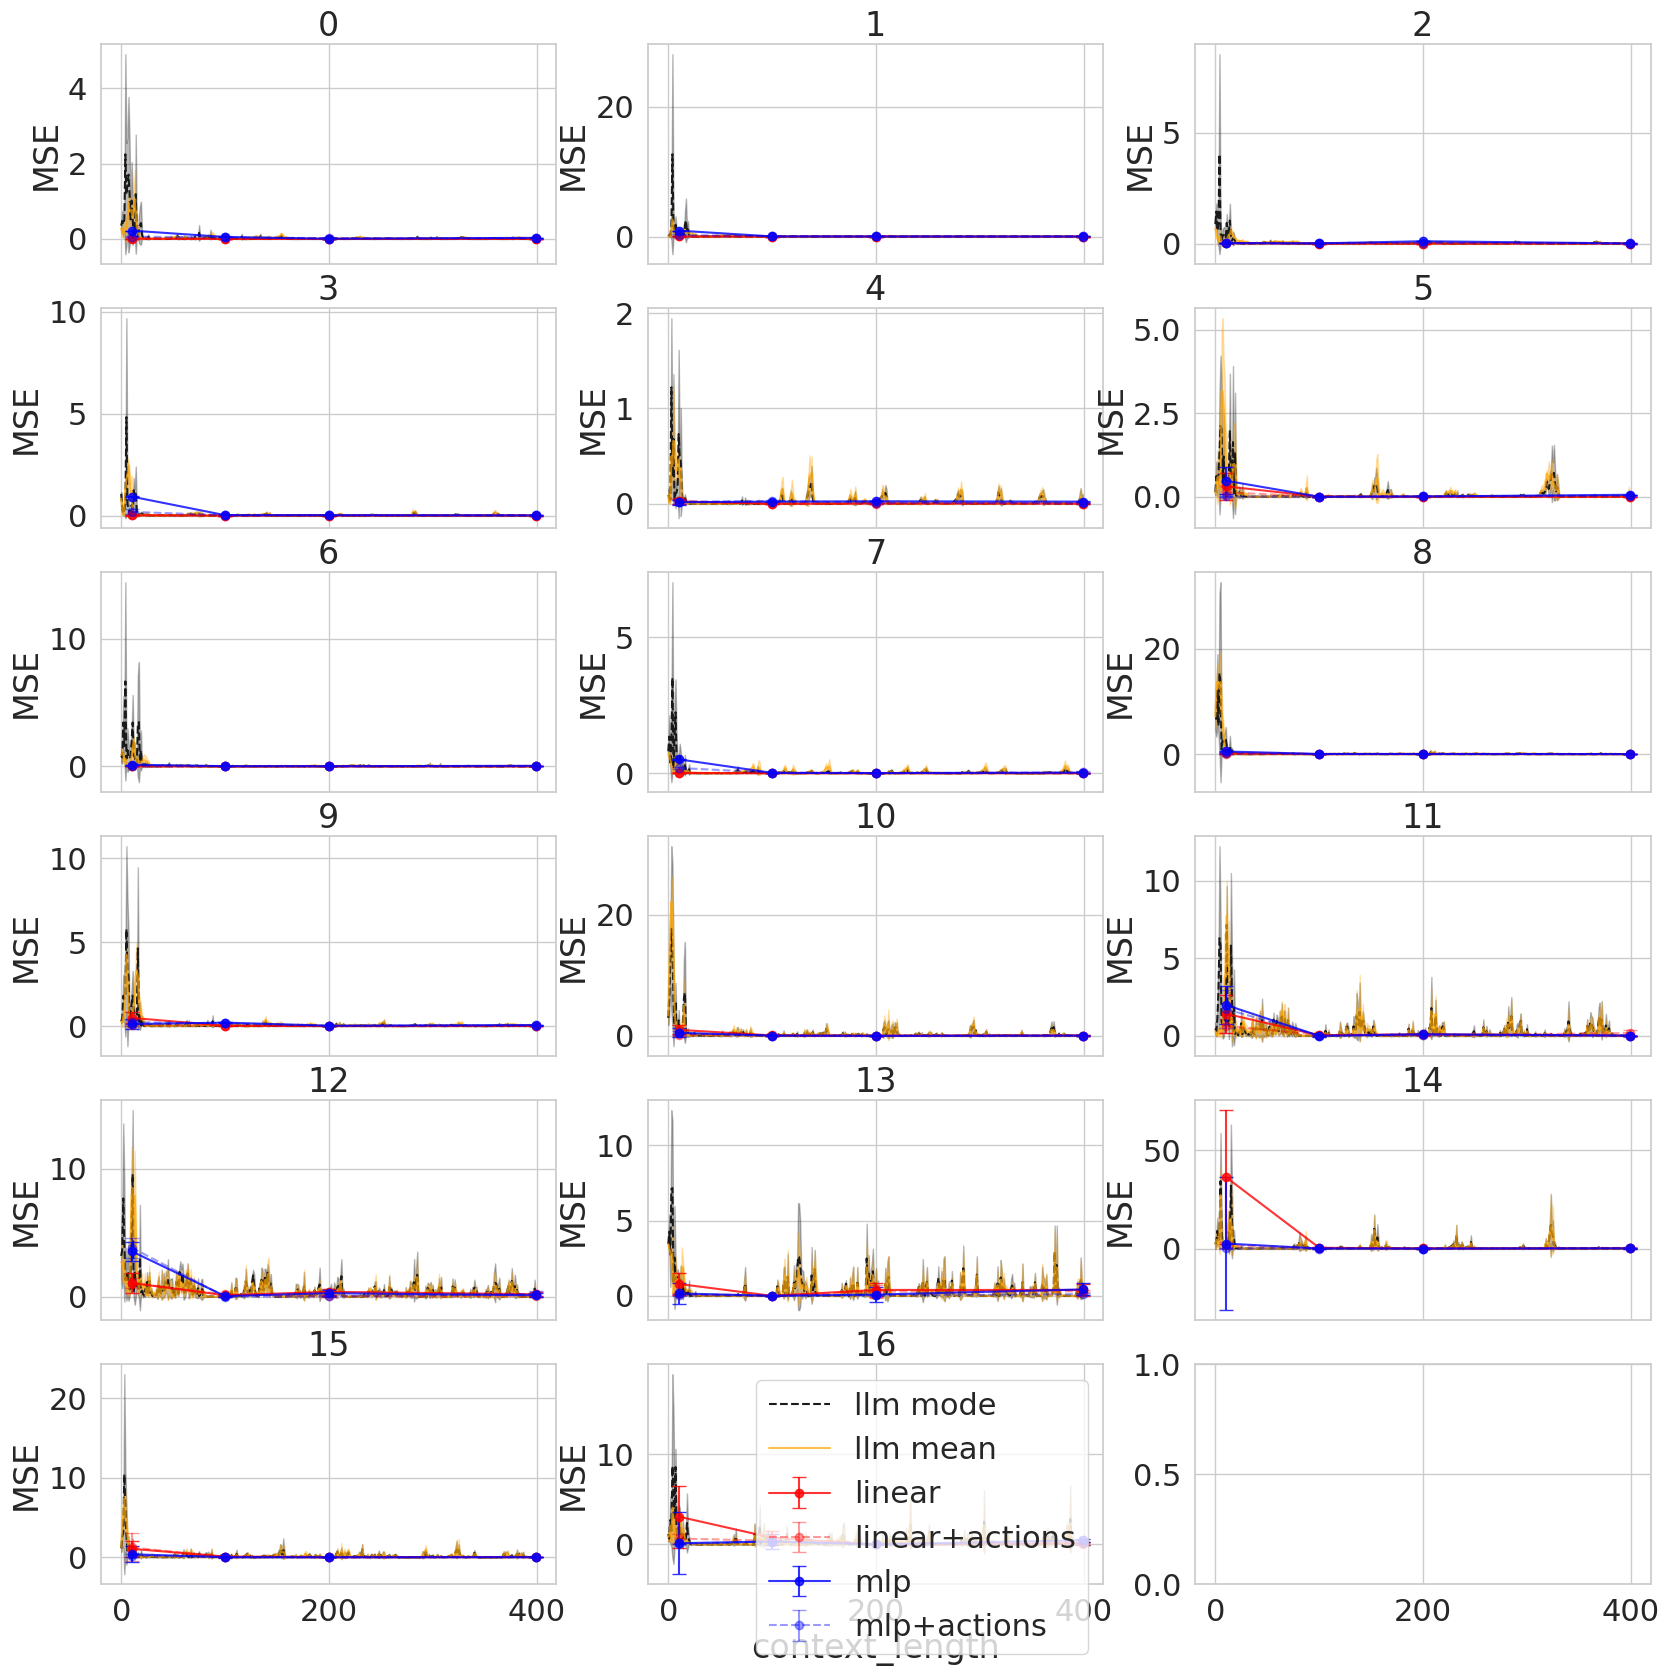

In [52]:
groundtruth = []
for episode in tqdm(selected_episodes, desc="episode"):
    groundtruth.append(
        scaling_pipeline.transform(
            X[episode + 1 : episode + context_length + 1, :n_observations]
        )[None, ...]
    )
groundtruth = np.concatenate(groundtruth, axis=0)

f, axes = plt.subplots(n_observations//3+1, 3, figsize=(20, 20), gridspec_kw={"wspace": 0.2}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    # -------------------- Useful for Plots --------------------
    mean_arr_all = mean_arr_all_pca[:, :, dim]
    mode_arr_all = mode_arr_all_pca[:, :, dim]

    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr_all.shape[1])
    mean_error = np.power(groundtruth[:, :, dim] - mean_arr_all, 2)
    mode_error = np.power(groundtruth[:, :, dim] - mode_arr_all, 2)

    axes[dim].plot(x, mode_error.mean(axis=0), "k--", label="llm mode")
    axes[dim].fill_between(
        x=x,
        y1=mode_error.mean(axis=0) - mode_error.std(axis=0),
        y2=mode_error.mean(axis=0) + mode_error.std(axis=0),
        color="k",
        alpha=0.3,
    )
    axes[dim].plot(
        x, mean_error.mean(axis=0), label="llm mean", color="orange", alpha=0.7
    )
    axes[dim].fill_between(
        x=x,
        y1=mean_error.mean(axis=0) - mean_error.std(axis=0),
        y2=mean_error.mean(axis=0) + mean_error.std(axis=0),
        color="orange",
        alpha=0.3,
    )
    # -------------------- Baselines --------------------
    # ------- Linear ----------
    linreg_error = np.power(
        linreg_pred_all_episodes[:, :, dim]
        - groundtruth[:, [scs - 1 for scs in sub_context_size_list], dim],
        2,
    )
    linreg_actions_error = np.power(
        linreg_actions_pred_all_episodes[:, :, dim]
        - groundtruth[:, [scs - 1 for scs in sub_context_size_list], dim],
        2,
    )
    axes[dim].errorbar(
        sub_context_size_list,
        linreg_error.mean(axis=0),
        yerr=linreg_error.std(axis=0),
        fmt="o-",
        color="red",
        ecolor="red",
        capsize=5,
        label="linear",
        alpha=0.8,
    )
    axes[dim].errorbar(
        sub_context_size_list,
        linreg_actions_error.mean(axis=0),
        yerr=linreg_actions_error.std(axis=0),
        fmt="o--",
        color="red",
        ecolor="red",
        capsize=5,
        label="linear+actions",
        alpha=0.4,
    )
    # ------- MLP ----------
    mlp_error = np.power(
        mlp_pred_all_episodes[:, :, dim]
        - groundtruth[:, [scs - 1 for scs in sub_context_size_list], dim],
        2,
    )
    mlp_actions_error = np.power(
        mlp_actions_pred_all_episodes[:, :, dim]
        - groundtruth[:, [scs - 1 for scs in sub_context_size_list], dim],
        2,
    )
    axes[dim].errorbar(
        sub_context_size_list,
        mlp_error.mean(axis=0),
        yerr=linreg_error.std(axis=0),
        fmt="o-",
        color="blue",
        ecolor="blue",
        capsize=5,
        label="mlp",
        alpha=0.8,
    )
    axes[dim].errorbar(
        sub_context_size_list,
        mlp_actions_error.mean(axis=0),
        yerr=mlp_actions_error.std(axis=0),
        fmt="o--",
        color="blue",
        ecolor="blue",
        capsize=5,
        label="mlp+actions",
        alpha=0.4,
    )

    axes[dim].set_title(f"{dim}")
    if dim > 15:
        axes[dim].set_xlabel("context_length")
    axes[dim].set_ylabel("MSE")
axes[dim].legend()
# plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
plt.show()

# Multi-step prediction

## llm

In [59]:
n_episodes = 10
context_length = 400
prediction_horizon = 10
rescale_factor = 7.0
up_shift = 1.5

icl_objects_list = []

print(f"episode starts: {episode_starts}")
selected_episodes = []
for episode in tqdm(np.random.choice(episode_starts, (n_episodes,)), desc="episode"):
    selected_episodes.append(episode)
    if pca_with_actions:
        time_series = pca.transform(
            scaling_pipeline_act.transform(
                X[episode : episode + context_length, :n_components]
            )
        )
    else:
        time_series = pca.transform(
            scaling_pipeline.transform(
                X[episode : episode + context_length, :n_components]
            )
        )

    trainer = trainers.RLICLTrainer(
        model=model,
        tokenizer=tokenizer,
        n_observations=n_components,
        n_actions=n_actions,
        rescale_factor=rescale_factor,
        up_shift=up_shift,
    )

    trainer.update_context(
        time_series=copy.copy(time_series),
        mean_series=copy.copy(time_series),
        sigma_series=np.zeros_like(time_series),
        context_length=context_length,
        update_min_max=True,
    )
    stochastic = False
    trainer.icl(verbose=0, stochastic=stochastic)

    icl_object = trainer.predict_long_horizon_llm(
        prediction_horizon=prediction_horizon,
        stochastic=stochastic,
        verbose=1,
        if_true_mean_else_mode=False,
    )

    icl_objects_list.append(icl_object)

episode starts: [    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000 19000]


prediction_horizon: 100%|██████████| 10/10 [01:37<00:00,  9.73s/it]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr
prediction_horizon: 100%|██████████| 10/10 [01:40<00:00, 10.09s/it]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in l

## baselines

In [54]:
sub_context_size_list = [10, 50, 100, context_length-1]

linreg_pred_all_episodes = []
linreg_actions_pred_all_episodes = []
mlp_pred_all_episodes = []
mlp_actions_pred_all_episodes = []
for episode in tqdm(selected_episodes, desc="episode"):
    linreg_pred_all = []
    linreg_actions_pred_all = []
    mlp_pred_all = []
    mlp_actions_pred_all = []
    for i, sub_context_size in enumerate(sub_context_size_list):
        X_train_actions = scaling_pipeline_act.transform(
            copy.copy(
                np.concatenate(
                    [
                        X[episode : episode + sub_context_size, :n_observations],
                        X[
                            episode : episode + sub_context_size,
                            n_observations : n_observations + n_actions,
                        ],
                    ],
                    axis=1,
                )[:-1]
            )
        )  
        X_train = scaling_pipeline.transform(
            copy.copy(X[episode : episode + sub_context_size - 1, :n_observations])
        )
        y_train = scaling_pipeline.transform(
            copy.copy(X[episode + 1 : episode + sub_context_size, :n_observations])
        )

        nan_indices = np.unique(np.argwhere(np.isnan(X_train_actions))[:, 0])
        mask = np.ones(X_train_actions.shape[0], bool)
        mask[nan_indices] = False

        X_train = X_train[mask]
        X_train_actions = X_train_actions[mask]
        y_train = y_train[mask]

        # ------- Fit Linear regression -------
        linreg_model = LinearRegression(fit_intercept=True)
        linreg_model.fit(X_train, y_train)

        # ------- Fit Linear regression with actions -------
        linreg_actions_model = LinearRegression(fit_intercept=True)
        linreg_actions_model.fit(X_train_actions, y_train)

        # ------- Fit MLP -------
        mlp = nn_utils.NeuralNet(input_size=n_observations, output_size=n_observations)
        _, _, mlp = nn_utils.train_mlp(model=mlp, X_train=X_train, y_train=y_train)
        mlp.eval()

        # ------- Fit MLP with actions -------
        mlp_actions = nn_utils.NeuralNet(
            input_size=n_observations + n_actions, output_size=n_observations
        )
        _, _, mlp_actions = nn_utils.train_mlp(
            model=mlp_actions, X_train=X_train_actions, y_train=y_train
        )
        mlp_actions.eval()

        # prediction single-step or multi-step
        if i < len(sub_context_size_list) - 1:
            # ------- Linear regression -------
            linreg_input = scaling_pipeline.transform(
                X[
                    episode + sub_context_size - 1,
                    :n_observations,
                ][None, ...]
            ).squeeze()
            linreg_pred = linreg_model.predict(linreg_input[None, ...])

            # ------- Linear regression with actions -------
            linreg_actions_input = scaling_pipeline_act.transform(
                np.concatenate(
                    [
                        X[episode + sub_context_size - 1, :n_observations][None, ...],
                        X[
                            episode + sub_context_size - 1,
                            n_observations : n_observations + n_actions,
                        ][None, ...],
                    ],
                    axis=1,
                )
            )
            linreg_actions_pred = linreg_actions_model.predict(linreg_actions_input)

            # ------- MLP -------
            mlp_input = scaling_pipeline.transform(
                X[
                    episode + sub_context_size - 1,
                    :n_observations,
                ][None, ...]
            ).squeeze()
            mlp_pred = (
                mlp(torch.from_numpy(mlp_input[None, ...]).type(torch.FloatTensor))
                .cpu()
                .detach()
                .numpy()
            )

            # ------- MLP with actions -------
            mlp_input_actions = scaling_pipeline_act.transform(
                np.concatenate(
                    [
                        X[episode + sub_context_size - 1, :n_observations][None, ...],
                        X[
                            episode + sub_context_size - 1,
                            n_observations : n_observations + n_actions,
                        ][None, ...],
                    ],
                    axis=1,
                )
            )
            mlp_actions_pred = (
                mlp_actions(torch.from_numpy(mlp_input_actions).type(torch.FloatTensor))
                .cpu()
                .detach()
                .numpy()
            )
        else:
            # ------- Linear regression -------
            linreg_input = scaling_pipeline.transform(
                X[
                    episode + sub_context_size - 1 : episode
                    + sub_context_size
                    - 1
                    + prediction_horizon,
                    :n_observations,
                ]
            )
            linreg_pred = linreg_model.predict(linreg_input)
            for h in range(prediction_horizon - 1):
                new_pred = linreg_model.predict(linreg_pred[h][None, ...])
                linreg_pred[h + 1] = copy.copy(new_pred)
            # linreg_pred = linreg_pred[[0,-1]]

            # ------- Linear regression with actions -------
            linreg_input = scaling_pipeline_act.transform(
                np.concatenate(
                    [
                        X[
                            episode + sub_context_size - 1 : episode
                            + sub_context_size
                            - 1
                            + prediction_horizon,
                            :n_observations,
                        ],
                        X[
                            episode + sub_context_size - 1 : episode
                            + sub_context_size
                            - 1
                            + prediction_horizon,
                            n_observations : n_observations + n_actions,
                        ],
                    ],
                    axis=1,
                )
            )
            linreg_actions_pred = linreg_actions_model.predict(linreg_input)
            # multi-step prediction
            for h in range(prediction_horizon - 1):
                # linear + actions
                new_input_actions = np.concatenate(
                    [
                        linreg_actions_pred[h][None, ...],
                        linreg_input[
                            h,
                            n_observations : n_observations + n_actions,
                        ][None, ...],
                        # TODO: halfcheetah have obs_reward as additional obs
                    ],
                    axis=1,
                )
                new_pred_actions = linreg_actions_model.predict(new_input_actions)
                linreg_actions_pred[h + 1] = copy.copy(new_pred_actions)
            # linreg_actions_pred = linreg_actions_pred[[0,-1]]

            # ------- MLP -------
            mlp_input = scaling_pipeline.transform(
                X[
                    episode + sub_context_size - 1 : episode
                    + sub_context_size
                    - 1
                    + prediction_horizon,
                    :n_observations,
                ]
            )
            mlp_pred = (
                mlp(torch.from_numpy(mlp_input).type(torch.FloatTensor))
                .cpu()
                .detach()
                .numpy()
            )
            for h in range(prediction_horizon - 1):
                new_pred = (
                    mlp(
                        torch.from_numpy(mlp_pred[h][None, ...]).type(torch.FloatTensor)
                    )
                    .cpu()
                    .detach()
                    .numpy()
                )
                mlp_pred[h + 1] = copy.copy(new_pred)
            # mlp_pred = mlp_pred[[0,-1]]

            # ------- MLP with actions -------
            mlp_input_actions = scaling_pipeline_act.transform(
                np.concatenate(
                    [
                        X[
                            episode + sub_context_size - 1 : episode
                            + sub_context_size
                            - 1
                            + prediction_horizon,
                            :n_observations,
                        ],
                        X[
                            episode + sub_context_size - 1 : episode
                            + sub_context_size
                            - 1
                            + prediction_horizon,
                            n_observations : n_observations + n_actions,
                        ],
                    ],
                    axis=1,
                )
            )
            mlp_actions_pred = (
                mlp_actions(torch.from_numpy(mlp_input_actions).type(torch.FloatTensor))
                .cpu()
                .detach()
                .numpy()
            )
            # multi-step prediction
            for h in range(prediction_horizon - 1):
                new_input_actions = np.concatenate(
                    [
                        mlp_actions_pred[h][None, ...],
                        mlp_input_actions[
                            h,
                            n_observations : n_observations + n_actions,
                        ][None, ...],
                        # TODO: halfcheetah have obs_reward as additional obs
                    ],
                    axis=1,
                )
                new_pred_actions = (
                    mlp_actions(
                        torch.from_numpy(new_input_actions).type(torch.FloatTensor)
                    )
                    .cpu()
                    .detach()
                    .numpy()
                )
                mlp_actions_pred[h + 1] = copy.copy(new_pred_actions)
            # mlp_actions_pred = mlp_actions_pred[[0,-1]]

        linreg_pred_all.append(linreg_pred)
        linreg_actions_pred_all.append(linreg_actions_pred)
        mlp_pred_all.append(mlp_pred)
        mlp_actions_pred_all.append(mlp_actions_pred)

    linreg_pred_all_episodes.append(np.concatenate(linreg_pred_all, axis=0)[None, ...])
    linreg_actions_pred_all_episodes.append(
        np.concatenate(linreg_actions_pred_all, axis=0)[None, ...]
    )
    mlp_pred_all_episodes.append(np.concatenate(mlp_pred_all, axis=0)[None, ...])
    mlp_actions_pred_all_episodes.append(
        np.concatenate(mlp_actions_pred_all, axis=0)[None, ...]
    )

linreg_pred_all_episodes = np.concatenate(linreg_pred_all_episodes, axis=0)
linreg_actions_pred_all_episodes = np.concatenate(
    linreg_actions_pred_all_episodes, axis=0
)
mlp_pred_all_episodes = np.concatenate(mlp_pred_all_episodes, axis=0)
mlp_actions_pred_all_episodes = np.concatenate(mlp_actions_pred_all_episodes, axis=0)

episode:   0%|          | 0/3 [00:00<?, ?it/s]

episode: 100%|██████████| 3/3 [00:19<00:00,  6.40s/it]


## vizu

In [55]:
# sub_context_size_list = [10, 50, 100, context_length-1]

data = {
    'Category': state_names[env_name],
}

episode: 100%|██████████| 3/3 [00:00<00:00, 1813.36it/s]


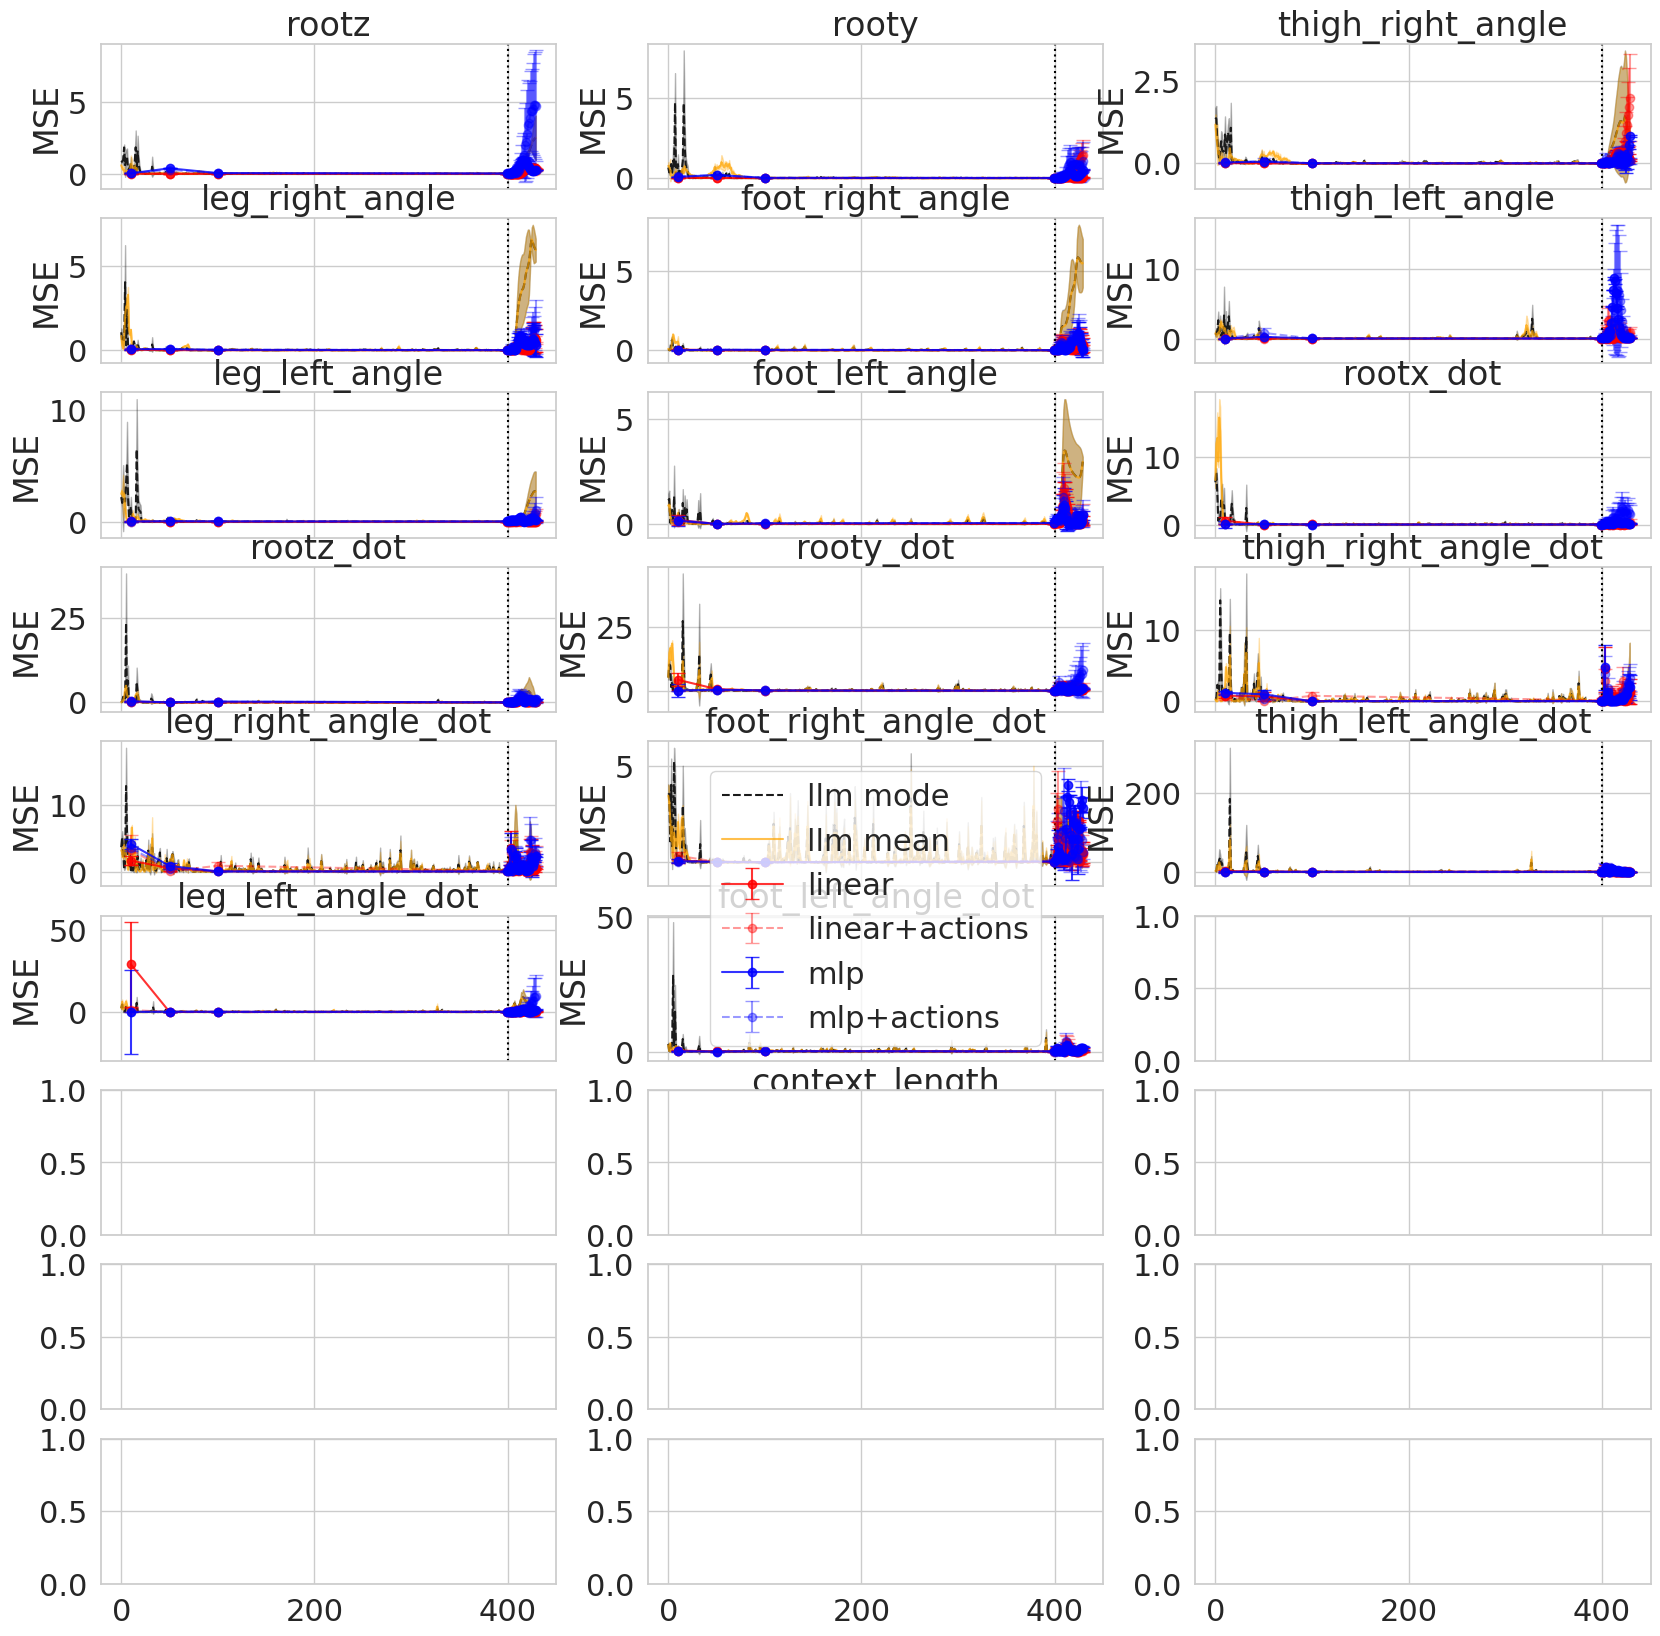

{'Category': ['rootz', 'rooty', 'thigh_right_angle', 'leg_right_angle', 'foot_right_angle', 'thigh_left_angle', 'leg_left_angle', 'foot_left_angle', 'rootx_dot', 'rootz_dot', 'rooty_dot', 'thigh_right_angle_dot', 'leg_right_angle_dot', 'foot_right_angle_dot', 'thigh_left_angle_dot', 'leg_left_angle_dot', 'foot_left_angle_dot'], 'linear': [0.17921588190391616, 0.028481320085292267, 0.17653782614768568, 0.17384984277262397, 0.29643434467154084, 0.20685713904130323, 0.07045049575503164, 0.25710488342469995, 0.04289567929651387, 0.30755142701471716, 0.42291753912565977, 0.43462163578529267, 0.6794804694993282, 0.8344031975041061, 1.582510444081078, 0.27054762427611073, 0.44892532303947996], 'linear+actions': [0.1830753265967628, 0.3697688325219242, 0.32460506422564817, 0.1885668823907317, 0.2592677454673177, 0.7963652143319753, 0.11872151326409831, 0.3335702534352027, 0.10082808923943176, 0.25561783988284176, 0.742356309687158, 0.9434411533715512, 0.965209261883583, 0.5347760634734489, 1.5

In [56]:
# Initialize lists to store the arrays for each dimension
mean_arr_list = []
mode_arr_list = []

for dim in range(n_components):
    mean_arr_dim = [
        (
            ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor)
            * (icl_object[dim].rescaling_max - icl_object[dim].rescaling_min)
            + icl_object[dim].rescaling_min
        )[None, ...]
        for icl_object in icl_objects_list
    ]
    mean_arr_dim = np.concatenate(mean_arr_dim, axis=0)
    mean_arr_list.append(mean_arr_dim)

    mode_arr_dim = [
        (
            ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor)
            * (icl_object[dim].rescaling_max - icl_object[dim].rescaling_min)
            + icl_object[dim].rescaling_min
        )[None, ...]
        for icl_object in icl_objects_list
    ]
    mode_arr_dim = np.concatenate(mode_arr_dim, axis=0)
    mode_arr_list.append(mode_arr_dim)

# Stack the arrays along the last dimension
mean_arr_all_pca = np.stack(mean_arr_list, axis=-1)
mode_arr_all_pca = np.stack(mode_arr_list, axis=-1)

mean_arr_all_pca = pca.inverse_transform(mean_arr_all_pca)
mode_arr_all_pca = pca.inverse_transform(mode_arr_all_pca)

data_linreg_error = []
data_linreg_act_error = []
data_mlp_error = []
data_mlp_act_error = []
data_llm_mean = []
data_llm_mode = []

groundtruth = []
for episode in tqdm(selected_episodes, desc="episode"):
    groundtruth.append(
        scaling_pipeline.transform(
            X[
                episode + 1 : episode + context_length + 1 + prediction_horizon,
                :n_observations,
            ]
        )[None, ...]
    )
groundtruth = np.concatenate(groundtruth, axis=0)

f, axes = plt.subplots(9, 3, figsize=(20, 20), gridspec_kw={"wspace": 0.2}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    # -------------------- Useful for Plots --------------------
    mean_arr_all = mean_arr_all_pca[:, :, dim]
    mode_arr_all = mode_arr_all_pca[:, :, dim]

    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr_all.shape[1])
    mean_error = np.power(groundtruth[:n_episodes, :, dim] - mean_arr_all, 2)
    mode_error = np.power(groundtruth[:n_episodes, :, dim] - mode_arr_all, 2)

    data_llm_mode.append(mode_error.mean(axis=0)[-prediction_horizon:].mean())
    data_llm_mean.append(mean_error.mean(axis=0)[-prediction_horizon:].mean())

    axes[dim].plot(x, mode_error.mean(axis=0), "k--", label="llm mode")
    axes[dim].fill_between(
        x=x,
        y1=mode_error.mean(axis=0) - mode_error.std(axis=0),
        y2=mode_error.mean(axis=0) + mode_error.std(axis=0),
        color="k",
        alpha=0.3,
    )
    axes[dim].plot(
        x, mean_error.mean(axis=0), label="llm mean", color="orange", alpha=0.7
    )
    axes[dim].fill_between(
        x=x,
        y1=mean_error.mean(axis=0) - mean_error.std(axis=0),
        y2=mean_error.mean(axis=0) + mean_error.std(axis=0),
        color="orange",
        alpha=0.3,
    )
    # -------------------- Baselines --------------------
    # ------- Linear ----------
    x_baselines = sub_context_size_list + list(
        np.arange(context_length + 1, context_length + prediction_horizon)
    )
    # print(f"x_baselines: {x_baselines}")
    # print(f"linreg_pred_all_episodes: {linreg_pred_all_episodes.shape}")
    # print(f"indices: {[scs - 1 for scs in x_baselines]}")
    linreg_error = np.power(
        linreg_pred_all_episodes[:, :, dim]
        - groundtruth[:n_episodes, [scs - 1 for scs in x_baselines], dim],
        2,
    )
    linreg_actions_error = np.power(
        linreg_actions_pred_all_episodes[:, :, dim]
        - groundtruth[:n_episodes, [scs - 1 for scs in x_baselines], dim],
        2,
    )
    axes[dim].errorbar(
        x_baselines,
        linreg_error.mean(axis=0),
        yerr=linreg_error.std(axis=0),
        fmt="o-",
        color="red",
        ecolor="red",
        capsize=5,
        label="linear",
        alpha=0.8,
    )
    axes[dim].errorbar(
        x_baselines,
        linreg_actions_error.mean(axis=0),
        yerr=linreg_actions_error.std(axis=0),
        fmt="o--",
        color="red",
        ecolor="red",
        capsize=5,
        label="linear+actions",
        alpha=0.4,
    )
    data_linreg_error.append(linreg_error.mean(axis=0)[-prediction_horizon:].mean())
    data_linreg_act_error.append(
        linreg_actions_error.mean(axis=0)[-prediction_horizon:].mean()
    )
    # ------- MLP ----------
    mlp_error = np.power(
        mlp_pred_all_episodes[:, :, dim]
        - groundtruth[:n_episodes, [scs - 1 for scs in x_baselines], dim],
        2,
    )
    mlp_actions_error = np.power(
        mlp_actions_pred_all_episodes[:, :, dim]
        - groundtruth[:n_episodes, [scs - 1 for scs in x_baselines], dim],
        2,
    )
    data_mlp_error.append(mlp_error.mean(axis=0)[-prediction_horizon:].mean())
    data_mlp_act_error.append(
        mlp_actions_error.mean(axis=0)[-prediction_horizon:].mean()
    )
    axes[dim].errorbar(
        x_baselines,
        mlp_error.mean(axis=0),
        yerr=linreg_error.std(axis=0),
        fmt="o-",
        color="blue",
        ecolor="blue",
        capsize=5,
        label="mlp",
        alpha=0.8,
    )
    axes[dim].errorbar(
        x_baselines,
        mlp_actions_error.mean(axis=0),
        yerr=mlp_actions_error.std(axis=0),
        fmt="o--",
        color="blue",
        ecolor="blue",
        capsize=5,
        label="mlp+actions",
        alpha=0.4,
    )

    axes[dim].axvline(x=context_length, color="black", linestyle=":")
    axes[dim].set_title(f"{state_names[env_name][dim]}")
    if dim > 15:
        axes[dim].set_xlabel("context_length")
    axes[dim].set_ylabel("MSE")
axes[dim].legend()
plt.savefig(
    f"/home/abenechehab/llmicl/src/llmicl/artifacts/figures/baselines|{env_name}.png"
)
plt.show()

data["linear"] = data_linreg_error
data["linear+actions"] = data_linreg_act_error
data["mlp"] = data_mlp_error
data["mlp+actions"] = data_mlp_act_error
data["llm mean"] = data_llm_mean
data["llm mode"] = data_llm_mode

print(data)

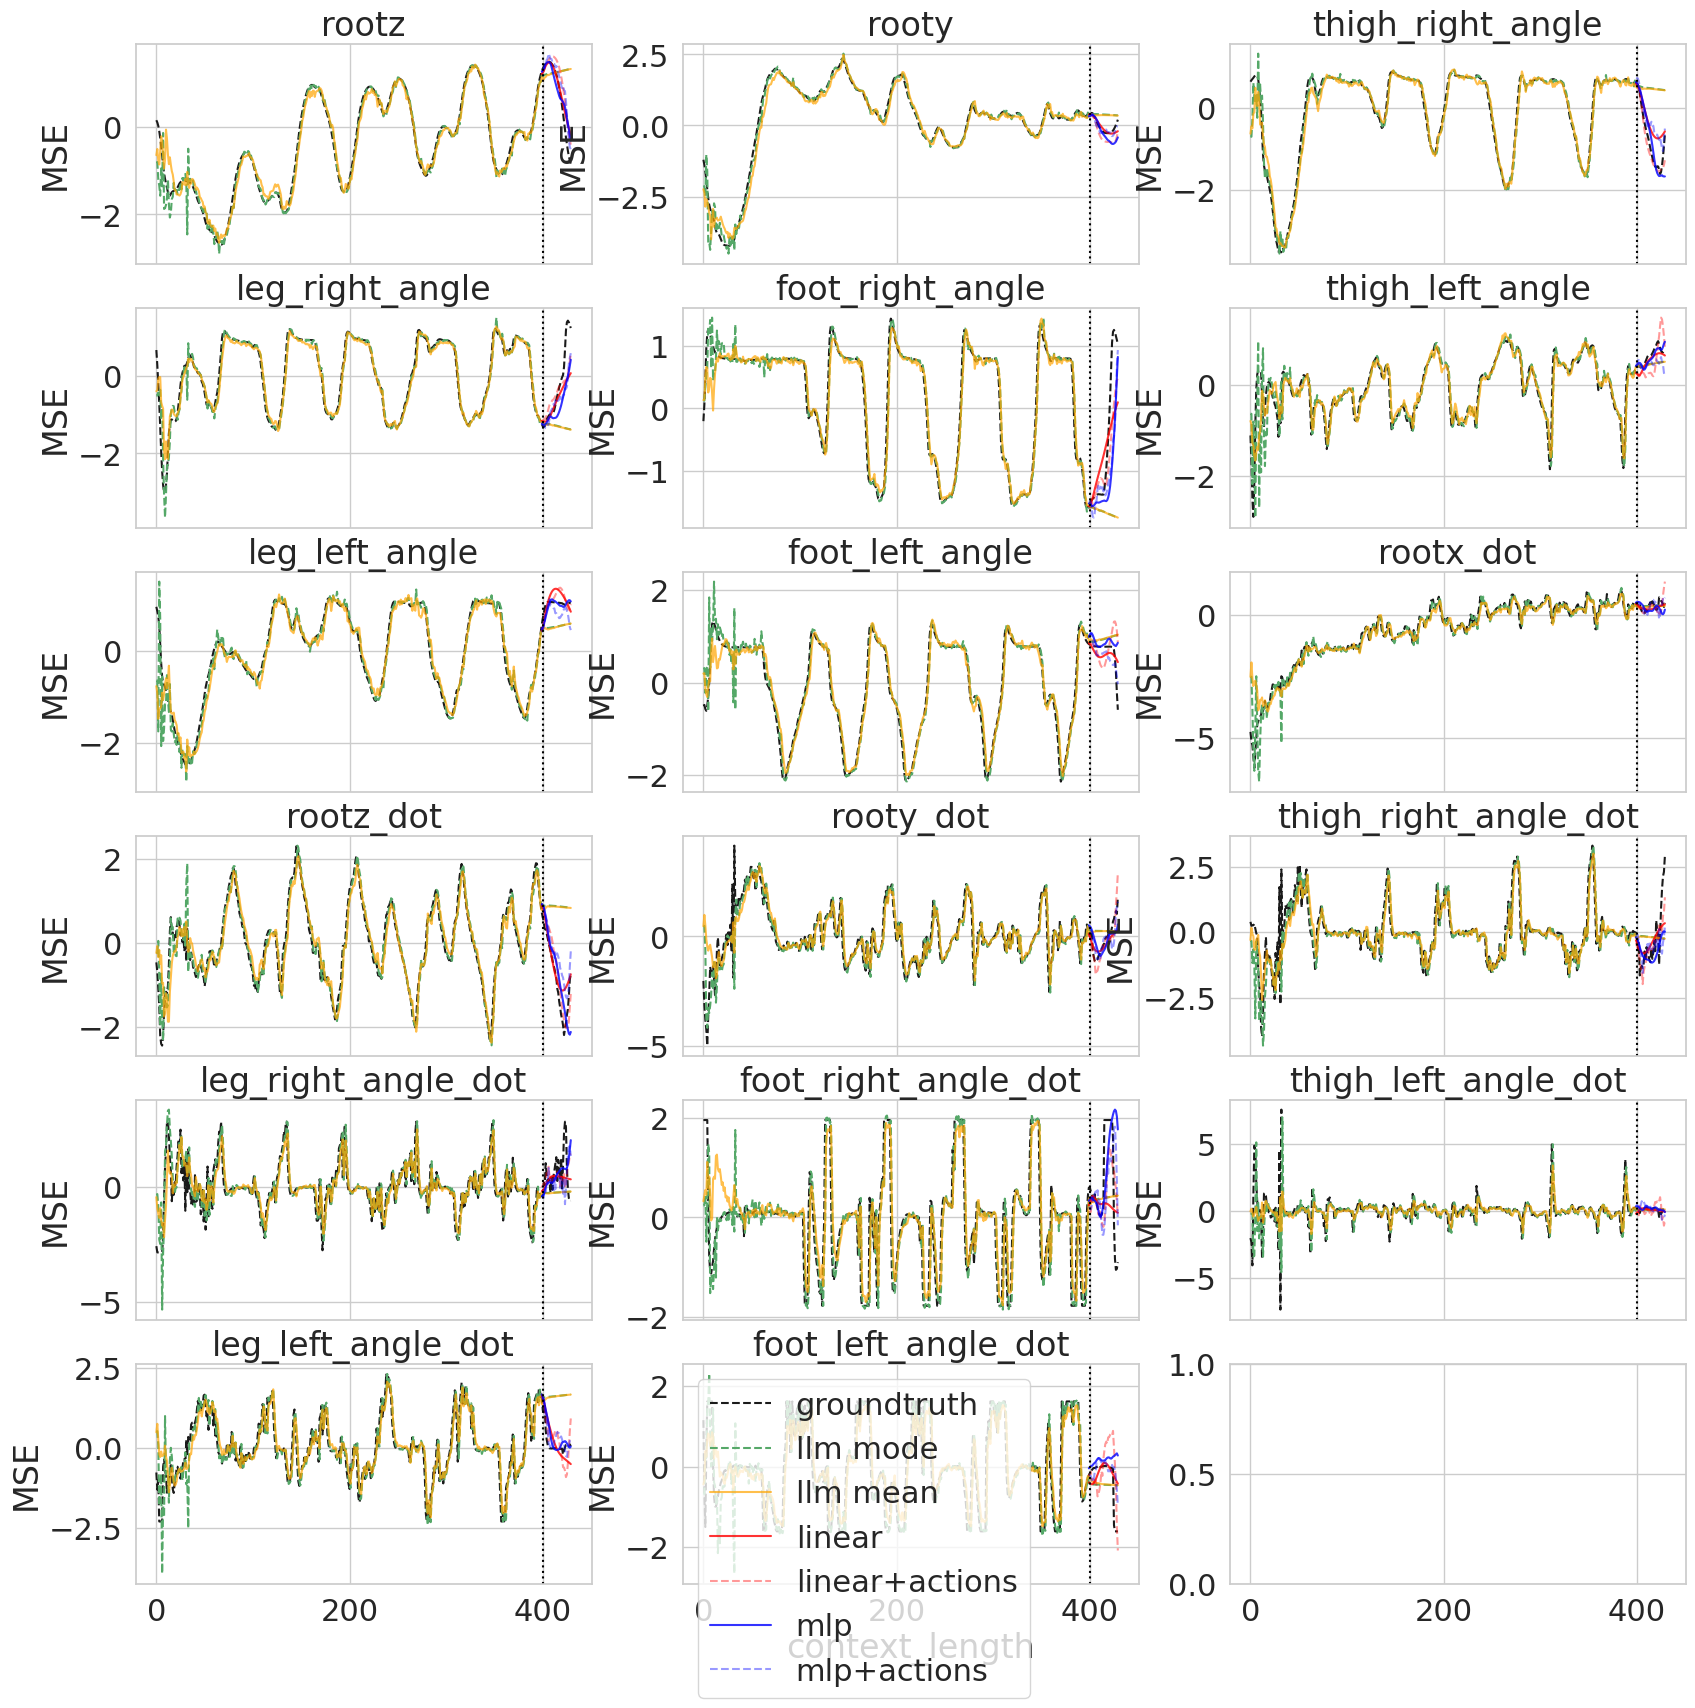

In [57]:
episode_idx = 2

groundtruth = []
for episode in selected_episodes:
    groundtruth.append(
        scaling_pipeline.transform(
            X[
                episode + 1 : episode + context_length + 1 + prediction_horizon,
                :n_observations,
            ]
        )[None, ...]
    )
groundtruth = np.concatenate(groundtruth, axis=0)[episode_idx]

f, axes = plt.subplots(
    (n_observations // 3) + 1,
    3,
    figsize=(20, 20),
    gridspec_kw={"wspace": 0.2},
    sharex=True,
)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    # -------------------- Useful for Plots --------------------
    mean_arr_all = mean_arr_all_pca[episode_idx, :, dim]
    mode_arr_all = mode_arr_all_pca[episode_idx, :, dim]

    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr_all.shape[0])

    axes[dim].plot(x, groundtruth[:, dim], "k--", label="groundtruth")

    axes[dim].plot(x, mode_arr_all, "g--", label="llm mode")
    # axes[dim].fill_between(
    #     x=x,
    #     y1=mode_error.mean(axis=0) - mode_error.std(axis=0),
    #     y2=mode_error.mean(axis=0) + mode_error.std(axis=0),
    #     color="k",
    #     alpha=0.3,
    # )
    axes[dim].plot(x, mean_arr_all, label="llm mean", color="orange", alpha=0.7)
    # axes[dim].fill_between(
    #     x=x,
    #     y1=mean_error.mean(axis=0) - mean_error.std(axis=0),
    #     y2=mean_error.mean(axis=0) + mean_error.std(axis=0),
    #     color="orange",
    #     alpha=0.3,
    # )
    # -------------------- Baselines --------------------
    # ------- Linear ----------
    x_baselines = sub_context_size_list + list(
        np.arange(context_length + 1, context_length + prediction_horizon)
    )
    # print(f"x_baselines: {x_baselines}")
    # print(f"linreg_pred_all_episodes: {linreg_pred_all_episodes.shape}")
    # print(f"indices: {[scs - 1 for scs in x_baselines]}")
    linreg_error = linreg_pred_all_episodes[episode_idx, :, dim]
    linreg_actions_error = linreg_actions_pred_all_episodes[episode_idx, :, dim]
    axes[dim].plot(
        x_baselines[-prediction_horizon:],
        linreg_error[-prediction_horizon:],
        color="red",
        label="linear",
        alpha=0.8,
    )
    axes[dim].plot(
        x_baselines[-prediction_horizon:],
        linreg_actions_error[-prediction_horizon:],
        color="red",
        label="linear+actions",
        alpha=0.4,
        linestyle="--",
    )
    # ------- MLP ----------
    mlp_error = mlp_pred_all_episodes[episode_idx, :, dim]
    mlp_actions_error = mlp_actions_pred_all_episodes[episode_idx, :, dim]
    axes[dim].plot(
        x_baselines[-prediction_horizon:],
        mlp_error[-prediction_horizon:],
        color="blue",
        label="mlp",
        alpha=0.8,
    )
    axes[dim].plot(
        x_baselines[-prediction_horizon:],
        mlp_actions_error[-prediction_horizon:],
        color="blue",
        label="mlp+actions",
        alpha=0.4,
        linestyle="--",
    )

    axes[dim].axvline(x=context_length, color="black", linestyle=":")
    axes[dim].set_title(f"{state_names[env_name][dim]}")
    if dim > 15:
        axes[dim].set_xlabel("context_length")
    axes[dim].set_ylabel("MSE")
axes[dim].legend()
# plt.savefig(
#     f"/home/abenechehab/llmicl/src/llmicl/artifacts/figures/baselines|{env_name}.png"
# )
plt.show()

## Radar chrt

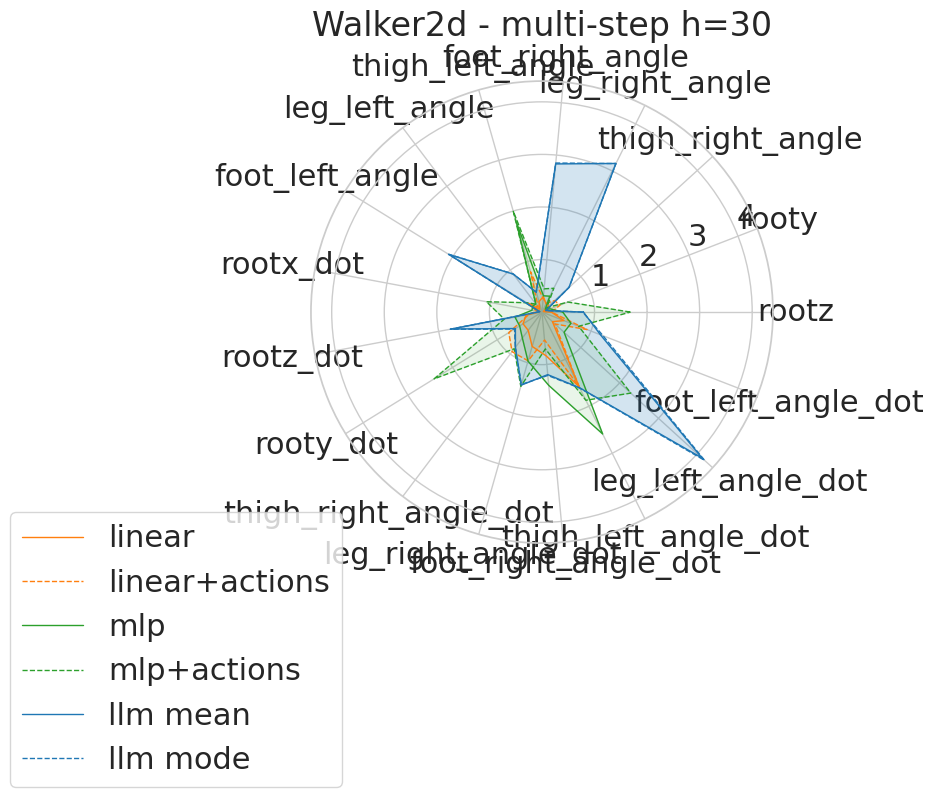

In [58]:
import matplotlib as mpl

# cmap = mpl.colormaps['tab10']
# colors = cmap(np.linspace(0, 1, 3))
cmap = mpl.colors.ListedColormap(plt.cm.tab10.colors[:3])

sty = {
    'llm mean': [cmap(0), '-'],
    'llm mode': [cmap(0), '--'],
    'linear': [cmap(1), '-'],
    'linear+actions': [cmap(1), '--'],
    'mlp': [cmap(2), '-'],
    'mlp+actions': [cmap(2), '--'],
}
# plt.style.use('seaborn-v0_8-classic')
# plt.style.use(['seaborn-v0_8-talk'])

df = pd.DataFrame(data)

# Number of variables
categories = list(df['Category'])
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# First dataset
for label in df.keys():
    if label != 'Category':
        values = df[label].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, label=label, color=sty[label][0], linestyle=sty[label][1])
        ax.fill(angles, values, alpha=0.1, color=sty[label][0])

# Add labels
plt.xticks(angles[:-1], categories)

# Add a title
plt.title(f'{env_name} - multi-step h={prediction_horizon}')

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

In [31]:
df.to_csv(f'/mnt/vdb/abenechehab/icl_paper/baselines_radar_chart_{env_name}_{data_label}_Nep{n_episodes}_predhorizon{prediction_horizon}.csv')

In [ ]:
print(plt.style.available)

In [38]:
data

{'Category': ['rootx',
  'rootz',
  'rooty',
  'joint_1_angle',
  'joint_2_angle',
  'rootx_dot',
  'rootz_dot',
  'rooty_dot',
  'joint_1_angle_dot',
  'joint_2_angle_dot'],
 'linear': [0.015433128290522135,
  0.030799982259631396,
  0.02950768527000692,
  0.2879718777170682,
  0.1189900427804607,
  0.1248903597796485,
  0.20696015050323702,
  0.1653463814130522],
 'linear+actions': [0.016777274742998602,
  0.018711331153868735,
  0.00674245729752692,
  0.2598283585464972,
  0.13660366941412855,
  0.1459776130334553,
  0.17358000777946497,
  0.07167664340794404],
 'mlp': [0.0025041581238085956,
  0.000617829226696058,
  0.0024861634732166733,
  0.17421731531555212,
  0.031432861735750696,
  0.03926107928301559,
  0.07448424261359596,
  0.1193127457878346],
 'mlp+actions': [0.005537816672853677,
  0.007499143092500243,
  0.004033880486247381,
  0.17068237957213653,
  0.10631400591143916,
  0.1079985593092357,
  0.14185038459704236,
  0.11625717211765545],
 'llm mean': [0.03490187184572